### Objectives

# 📈 Model Evaluation

## 🎯 Objective

This notebook evaluates the performance of the trained mildew detection model. We assess its predictive capability using various classification metrics and visual tools.

### Inputs

### Outputs

In [1]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import itertools

2025-06-04 15:05:17.565264: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Model Performance
I have made the below cell of code a raw simply because i don't want to keep re-creating and replacing the images on every instance where i decide to rerun all after restarting the kernel.

In [2]:
import pickle

# Load history from file
with open("../outputs/training_history_softmax.pkl", "rb") as f:
    history_data = pickle.load(f)

Because i don't want to re build and train the model;
 - i would comment out the section of the code that references the history and rather fetch from the history.
 - however, i still need to rebuild this time around so i get the data.

In [3]:
from tensorflow.keras.models import load_model

model = load_model("../outputs/mildew_model_softmax.keras")


### ✅ Accuracy and Loss Curves

We visualize training and validation accuracy/loss over epochs to assess:

- Whether the model is overfitting
- How well it converged during training

Plots are saved to the `outputs/` directory.

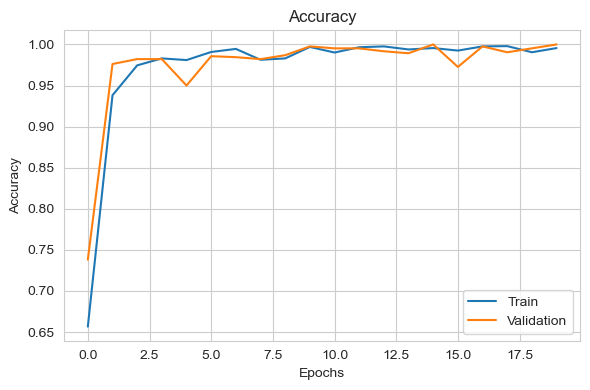

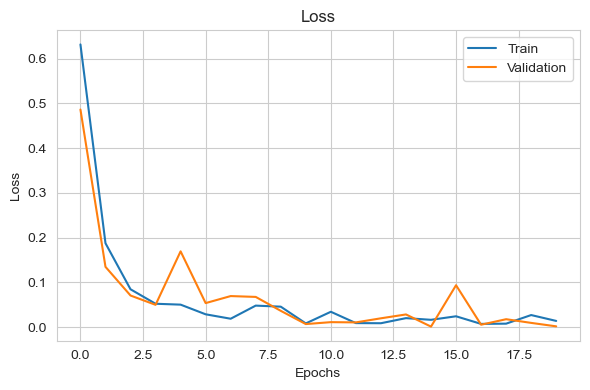

In [4]:
# Plot training & validation accuracy/loss
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

output_dir = Path("../outputs/plots")
output_dir.mkdir(exist_ok=True)
sns.set_style("whitegrid")

# --- Accuracy plot ---
plt.figure(figsize=(6, 4))
# plt.plot(history.history['accuracy'], label='Train')
# plt.plot(history.history['val_accuracy'], label='Validation')
plt.plot(history_data['accuracy'], label='Train')
plt.plot(history_data['val_accuracy'], label='Validation')

plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig(output_dir / "model_training_accuracy.png", bbox_inches='tight', dpi=150)
plt.show()
plt.close()

# --- Loss plot ---
plt.figure(figsize=(6, 4))
# plt.plot(history.history['loss'], label='Train')
# plt.plot(history.history['val_loss'], label='Validation')
plt.plot(history_data['loss'], label='Train')
plt.plot(history_data['val_loss'], label='Validation')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig(output_dir / "model_training_losses.png", bbox_inches='tight', dpi=150)
plt.show()
plt.close()


### 📦 Model Summary

We compute:

- Total parameters
- Trainable parameters
- Non-trainable parameters

This helps understand the model's complexity and potential deployment implications.


In [5]:
# Import json
import json

# model.count_params()
total_params = model.count_params()
trainable_params = sum([np.prod(v.shape) for v in model.trainable_weights])
non_trainable_params = total_params - trainable_params

model_summary = {
    "total_params": int(total_params),
    "trainable_params": int(trainable_params),
    "non_trainable_params": int(non_trainable_params)
}

with open('../outputs/model_summary.json', 'w') as f:
    json.dump(model_summary, f)


### 🧾 Classification Report

We generate a report based on predictions from the validation set, including:

- Precision
- Recall
- F1-score
- Support

Saved as `classification_report.json`.


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_shape = (256, 256)
batch_size = 32

# Just use rescale (no augmentation for validation/test)
test_aug = ImageDataGenerator(rescale=1./255)

val_data = test_aug.flow_from_directory(
    "../inputs/split-leaves/validation",
    target_size=img_shape,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 840 images belonging to 2 classes.


In [9]:
# # from sklearn.metrics import classification_report
# import numpy as np
# import json

# # Ensure predictions are limited to one full pass over the validation set
# val_predictions = model.predict(val_data, steps=len(val_data), verbose=1)

# # Flatten predictions for binary classification
# val_pred_binary = (val_predictions > 0.5).astype(int).flatten()

# # Retrieve true labels directly from the generator
# val_labels = val_data.classes

# # Get class names from the generator (sorted by index)
# class_names = list(val_data.class_indices.keys())

# # Generate classification report
# report = classification_report(val_labels, val_pred_binary,
#                                target_names=class_names,
#                                output_dict=True)

# # Print report to console
# print("Classification Report:")
# print(classification_report(val_labels, val_pred_binary, target_names=class_names))

# # Save report to JSON
# output_path = "../outputs/classification_report.json"
# with open(output_path, "w") as f:
#     json.dump(report, f, indent=4)
# print(f"Classification report saved to {output_path}")


In [11]:
# from sklearn.metrics import classification_report
import numpy as np
import json

# Ensure predictions are limited to one full pass over the validation set
val_predictions = model.predict(val_data, verbose=1)  

# Retrieve true labels directly from the generator
val_pred_labels = np.argmax(val_predictions, axis=1)

# val_labels = val_data.classes
val_labels = val_data.classes  


# Get class names from the generator (sorted by index)
class_names = list(val_data.class_indices.keys())

# Generate classification report
report = classification_report(
    val_labels,
    val_pred_labels,
    target_names=class_names,
    output_dict=True
)

# Print report to console
print("Classification Report:")
print(classification_report(val_labels, val_pred_labels, target_names=class_names))

# Save report to JSON
output_path = "../outputs/classification_report.json"
with open(output_path, "w") as f:
    json.dump(report, f, indent=4)
print(f"Classification report saved to {output_path}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 242ms/step
Classification Report:
                precision    recall  f1-score   support

       healthy       1.00      1.00      1.00       420
powdery_mildew       1.00      1.00      1.00       420

      accuracy                           1.00       840
     macro avg       1.00      1.00      1.00       840
  weighted avg       1.00      1.00      1.00       840

Classification report saved to ../outputs/classification_report.json


#### Generate and Plot Confusion Matrix

### 📉 Confusion Matrix

We visualize true/false positives and negatives using a heatmap, and save both the figure and matrix data.


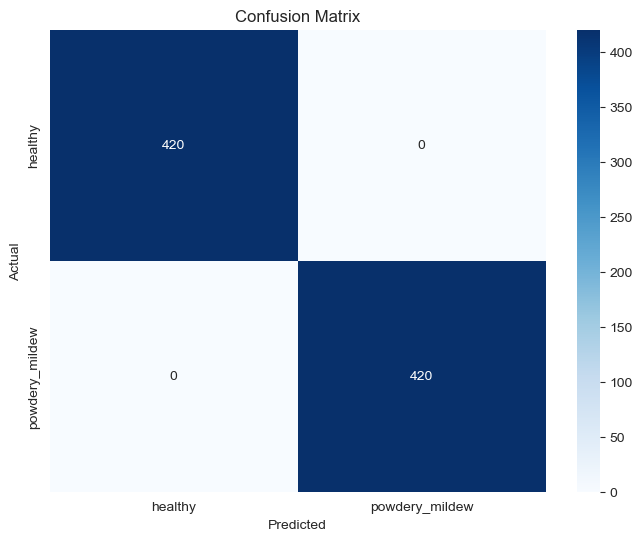

Confusion matrix saved to ../outputs/confusion_matrix.png


In [12]:
# Generate and Plot Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Generate confusion matrix - Using softmax calls for replacing binary with labels
# cm = confusion_matrix(val_labels, val_pred_binary)
cm = confusion_matrix(val_labels, val_pred_labels)

# Create confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Save confusion matrix plot
output_dir = Path("../outputs/plots")
output_dir.mkdir(exist_ok=True)
plt.savefig(output_dir / "confusion_matrix.png", bbox_inches='tight', dpi=150)
plt.show()

# Save confusion matrix as a JSON file
cm_list = cm.tolist()
with open("../outputs/confusion_matrix.json", "w") as f:
    json.dump(cm_list, f)

print("Confusion matrix saved to ../outputs/confusion_matrix.png")

### 📊Performance Summary

Additional metrics such as:

- Accuracy
- Precision
- Recall
- F1-score
- TP, TN, FP, FN counts

Saved to `performance_summary.json` for dashboard integration.

In [13]:
# Additional Model Performance Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate additional metrics
# accuracy = accuracy_score(val_labels, val_pred_binary)
accuracy = accuracy_score(val_labels, val_pred_labels)
precision = precision_score(val_labels, val_pred_labels)
# precision = precision_score(val_labels, val_pred_binary)
# recall = recall_score(val_labels, val_pred_binary)
recall = recall_score(val_labels, val_pred_labels)
f1 = f1_score(val_labels, val_pred_labels)
# f1 = f1_score(val_labels, val_pred_binary)

# Create performance summary
performance_summary = {
    "accuracy": float(accuracy),
    "precision": float(precision),
    "recall": float(recall),
    "f1_score": float(f1),
    "total_samples": len(val_labels),
    "true_positives": int(cm[1,1]),
    "true_negatives": int(cm[0,0]),
    "false_positives": int(cm[0,1]),
    "false_negatives": int(cm[1,0])
}

print("Performance Summary:")
for metric, value in performance_summary.items():
    print(f"{metric}: {value}")

# Save performance summary as JSON
with open("../outputs/performance_summary.json", "w") as f:
    json.dump(performance_summary, f, indent=4)

print("Performance summary saved to ../outputs/performance_summary.json")


Performance Summary:
accuracy: 1.0
precision: 1.0
recall: 1.0
f1_score: 1.0
total_samples: 840
true_positives: 420
true_negatives: 420
false_positives: 0
false_negatives: 0
Performance summary saved to ../outputs/performance_summary.json


### 🚦 ROC Curve & AUC

We generate and plot the ROC curve, along with the AUC score, which reflects the model's ability to distinguish between classes.

Saved as `roc_curve.png` and `roc_data.json`.


In [15]:
# import json
# from sklearn.metrics import roc_curve, auc

# # Calculate ROC data
# output_dir = Path("../outputs")
# fpr, tpr, thresholds = roc_curve(val_labels, val_predictions)
# roc_auc = auc(fpr, tpr)

# # Save the ROC data as JSON
# roc_data = {
#     "fpr": fpr.tolist(),
#     "tpr": tpr.tolist(),
#     "auc": roc_auc
# }

# with open(output_dir / "roc_data.json", "w") as f:
#     json.dump(roc_data, f)

# # (Optional) Also plot and save image if needed
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.tight_layout()
# plt.savefig(output_dir / "roc_curve.png", dpi=150)
# plt.close()

# print("ROC data saved to ../outputs/roc_data.json")

#### Softmax calls for this

In [20]:
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Ensure `val_predictions` is (N, 2) from softmax
# Select probabilities for the "positive" class (e.g., Powdery Mildew)
positive_class_index = 1  # change this if 'healthy' is index 1
positive_probs = val_predictions[:, positive_class_index]

# Compute ROC data
fpr, tpr, thresholds = roc_curve(val_labels, positive_probs)
roc_auc = auc(fpr, tpr)

# Save ROC data as JSON
output_dir = Path("../outputs")
roc_data = {
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
    "auc": roc_auc
}
with open(output_dir / "roc_data.json", "w") as f:
    json.dump(roc_data, f)

# Plot and save image
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(output_dir / "plots/roc_curve.png", dpi=150)
plt.close()

print("ROC data saved to ../outputs/roc_data.json")


ROC data saved to ../outputs/roc_data.json


### Consolidating Evaluation Data

Load 4 separate JSON evaluation files
 - (performance summary,
 - classification report,
 - confusion matrix,
 - ROC data) and
combined into a single dictionary.

Saved as `evaluation.pkl` using joblib for efficient storage of ML evaluation results.

In [17]:
import json
import joblib

# Load JSONs
with open("../outputs/performance_summary.json", "r") as f:
    perf_summary = json.load(f)

with open("../outputs/classification_report.json", "r") as f:
    class_report = json.load(f)

with open("../outputs/confusion_matrix.json", "r") as f:
    confusion_matrix = json.load(f)

with open("../outputs/roc_data.json", "r") as f:
    roc_data = json.load(f)

# Combine into one dict
evaluation = {
    "performance_summary": perf_summary,
    "classification_report": class_report,
    "confusion_matrix": confusion_matrix,
    "roc_data": roc_data
}

# Save to .pkl
joblib.dump(evaluation, "../outputs/evaluation.pkl")

print("✅ evaluation.pkl created.")


✅ evaluation.pkl created.


### 🔍 Sample Image Comparison and Predictions

To better understand the dataset and validate our model visually, we:

1. Loaded and saved one sample image per class (healthy vs. powdery mildew)
2. Created a side-by-side comparison of the two classes for dashboard presentation
3. Generated live predictions on random test images using the trained model
   - Displayed predicted label and confidence score
   - Compared against actual class

These visual outputs support both qualitative model evaluation and dashboard explanation.

### Fetch one image each from the loaded powery and healthy leaves

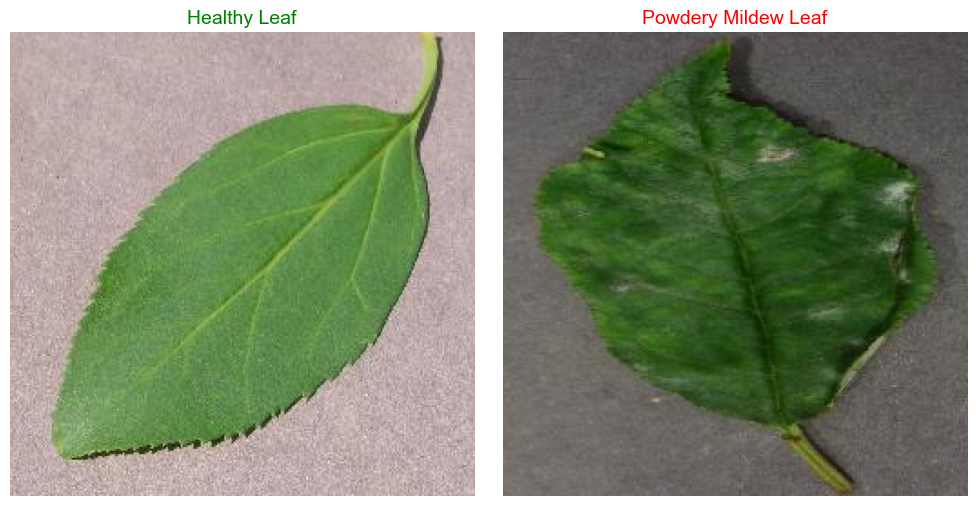

Saved:
- ../outputs/plots/healthy.png
- ../outputs/plots/mildew.png
- ../outputs/plots/healthy_vs_mildew.png


In [18]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

# Paths
test_path = "../inputs/split-leaves/test"
output_dir = "../outputs/plots"
labels = ["healthy", "powdery_mildew"]
healthy_output = os.path.join(output_dir, "healthy.png")
mildew_output = os.path.join(output_dir, "mildew.png")
combined_output = os.path.join(output_dir, "healthy_vs_mildew.png")

# Function to load one sample per class
def load_sample(class_name):
    img_list = os.listdir(os.path.join(test_path, class_name))
    img_file = img_list[0]  # Or use random.choice(img_list) for variety
    img_path = os.path.join(test_path, class_name, img_file)
    pil_image = image.load_img(img_path, target_size=(256, 256))
    return pil_image

# Load one image per class
healthy_img = load_sample("healthy")
mildew_img = load_sample("powdery_mildew")

# Save Healthy Image
plt.figure(figsize=(4, 4))
plt.imshow(healthy_img)
plt.title("Healthy Leaf", fontsize=14, color='green')
plt.axis("off")
plt.tight_layout()
plt.savefig(healthy_output, dpi=150)
plt.close()

# Save Mildew Image
plt.figure(figsize=(4, 4))
plt.imshow(mildew_img)
plt.title("Powdery Mildew Leaf", fontsize=14, color='red')
plt.axis("off")
plt.tight_layout()
plt.savefig(mildew_output, dpi=150)
plt.close()

# Save and Display Combined Image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(healthy_img)
axes[0].set_title("Healthy Leaf", fontsize=14, color='green')
axes[0].axis("off")

axes[1].imshow(mildew_img)
axes[1].set_title("Powdery Mildew Leaf", fontsize=14, color='red')
axes[1].axis("off")

plt.tight_layout()
plt.savefig(combined_output, dpi=150)
plt.show()

print(f"Saved:\n- {healthy_output}\n- {mildew_output}\n- {combined_output}")

### Predict on Random Data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


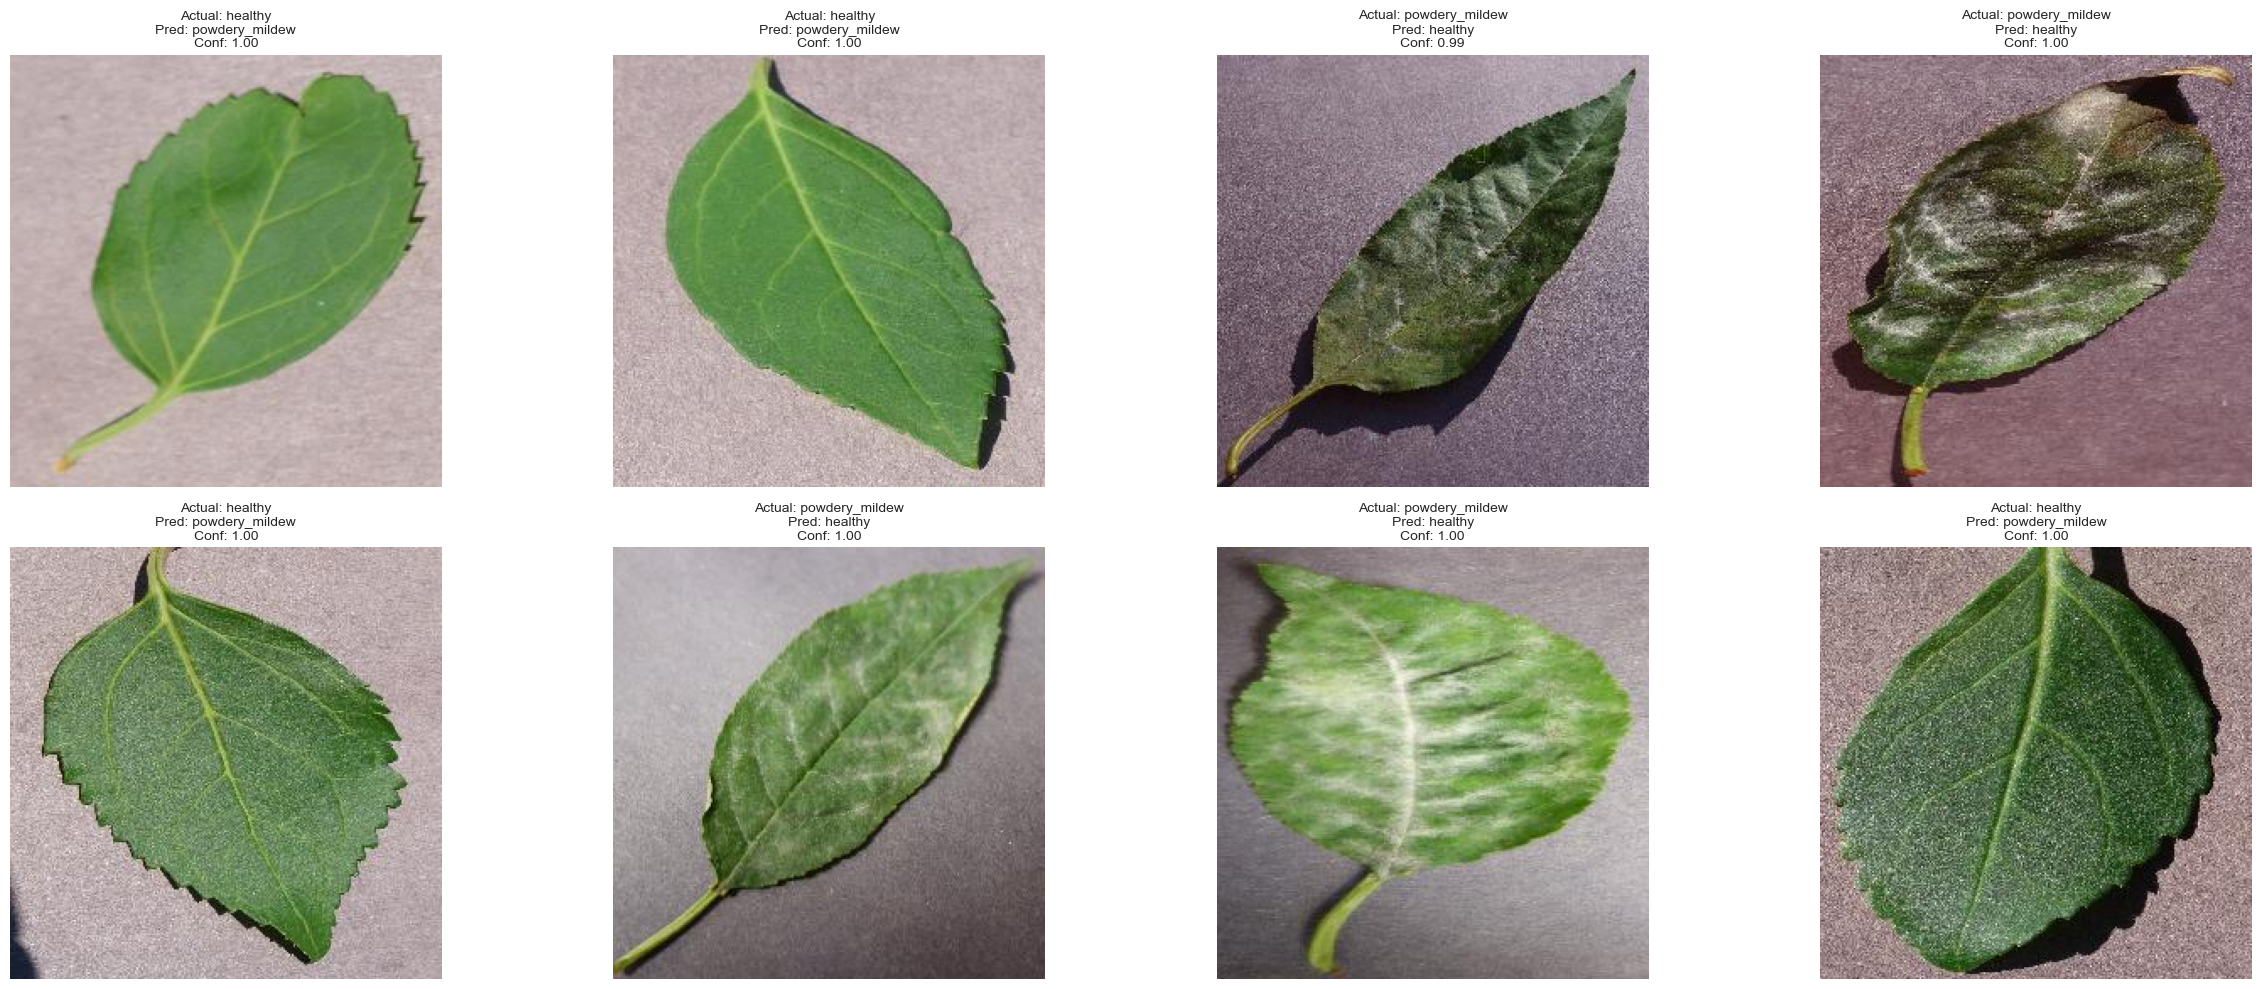

In [19]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# Setup
test_path = "../inputs/split-leaves/test"
labels = ["healthy", "powdery_mildew"]
num_preds = 8

# Create subplots
fig, axes = plt.subplots(2, 4, figsize=(25, 10))
axes = axes.flatten()  # Convert 2D array to 1D for easy indexing

for i in range(num_preds):
    label = random.choice(labels)
    img_list = os.listdir(os.path.join(test_path, label))
    pointer = random.randint(0, len(img_list) - 1)

    img_path = os.path.join(test_path, label, img_list[pointer])
    pil_image = image.load_img(img_path, target_size=(256, 256), color_mode='rgb')

    # Preprocess and predict
    img_array = image.img_to_array(pil_image)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    pred_proba = model.predict(img_array)[0, 0]
    pred_class = "powdery_mildew" if pred_proba > 0.5 else "healthy"
    confidence = pred_proba if pred_proba > 0.5 else 1 - pred_proba

    # Plot image with prediction title
    axes[i].imshow(pil_image)
    axes[i].axis("off")
    axes[i].set_title(f"Actual: {label}\nPred: {pred_class}\nConf: {confidence:.2f}", fontsize=10)

plt.tight_layout()
plt.savefig("../outputs/plots/sample_predictions.png", bbox_inches='tight', dpi=150)
plt.show()